In [1]:
!python --version

Python 3.10.12


#Downloading the dependcencies
* Create a Virtual Enviroment and make sure your machine has both CuDNN drivers for tensorlfow, also drivers compatible for the torch. This is beacuse on Cloud (Run Pod) for pytorch template this file will show error for Tensorflow driver's error.

* On collab this is easlity runnable
* Locally use VS Code with VIRE (Enviroment)



**`NOTE`**
* peft timm sentence piece specifically(restart vscode after downloading sentence piece)
* All the pip imports
* correct file paths for importing models and other files, and it will take time to load and download

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [4]:
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install scikit-learn --quiet
!pip install opencv-python --quiet
!pip install pillow --quiet
!pip install transformers==4.40.0 --quiet
!pip install torch --quiet
!pip install torchvision --quiet
!pip install pywavelets --quiet
!pip install  tqdm --quiet
!pip install opencv-python==4.6.0.66 --quiet
!pip install opencv-contrib-python==4.6.0.66 --quiet
!pip install gputil --quiet
!pip install timm --quiet
!pip install peft --quiet
!pip install sentencepiece --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 71.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 51.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer
from transformers import ViltProcessor, ViltForQuestionAnswering
import pywt
import cv2
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from PIL import Image
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from transformers import ViltProcessor, ViltForQuestionAnswering
from tensorflow.keras.models import load_model
import requests
from transformers import AutoModel, AutoTokenizer
from torchvision import transforms
import json
import tensorflow as tf
import time
import numpy as np
from IPython.display import clear_output

In [ ]:
#On collab infernece upload the zipfile if you need then do below ~(*.*)~
import zipfile
with zipfile.ZipFile('main\code\Input\perturbed_images_32' , 'r') as rp:  # change the directory according to your device
  rp.extractall('/content/')

In [7]:
print("PyTorch GPU Support:", torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

PyTorch GPU Support: True
GPU Device Name: Tesla T4


# File Configurations

**Make sure that these files are set according to your enviroment**

In [ ]:
# ------------------------- CONFIGURATION -------------------------
# Paths to saved models and artifact names
HYBRID_MODEL_PATH = 'main\models\hybrid_resnet_wavelet_model_saved.h5'
ARTIFACTS_FILE = "main\code\Input\ai-artifacts.txt"
ARTIFACT_MODEL_PATH = "dandelin/vilt-b32-finetuned-vqa"
SUPER_RES_MODEL_PATH = "main\models\EDSR_x4.pb"
PREDICTIONS_JSON_PATH = "predictions.json"
RESULTS_JSON_PATH = "artifact_detection_results.json"
EDSR_PATH = "main\models\EDSR_x4.pb"

# Confidence threshold for artifact detection
CONFIDENCE_THRESHOLD = 0.80
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Models for artefact detection

- To use our fine tuned models in the main file the path of ARTIFACT_MODEL_PATH needs to be changed

   - **For fine_tuned_40_12 model:** main\other_models\fine_tuned_vilt_model\fine_tuned_40_12\fine_tuned_model_40_12
   - **For fine_tuned_40_12 model:** main\other_models\fine_tuned_vilt_model\fine_tuned_40_14\fine_tuned_model_40_14
   - **For fine_tuned_40_12 model:** main\other_models\fine_tuned_vilt_model\fine_tuned_40_13\fine_tuned_model_40_13   
   - **For fine_tuned_40_12 model:** main\other_models\fine_tuned_vilt_model\fine_tuned_40_23\fine_tuned_model_40_23
   

# Loading the Models

* Some models are laoded into the GPUs (if avaiable) for faster infernece
* For using MiniCPM 8.1B use

```
AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True, torch_dtype=torch.bfloat16)
AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True)

```
* For using MiniCPM Llama V 2.5  - 8.54B

```
AutoModel.from_pretrained('openbmb/MiniCPM-Llama3-V-2_5', trust_remote_code=True, torch_dtype=torch.float16)
AutoTokenizer.from_pretrained('openbmb/MiniCPM-Llama3-V-2_5', trust_remote_code=True)
```

* You can find the model we've used for explanation generation: https://huggingface.co/openbmb/MiniCPM-V-2 

***We are using only MiniCPM-V-2 which is 3.43B of size!***


In [9]:
# ------------------------- LOAD MODELS -------------------------
# Load Hybrid ResNet model
print("Loading Hybrid ResNet model...")
hybrid_model = load_model(HYBRID_MODEL_PATH)
print("Hybrid ResNet model loaded successfully.")

# Load artifact detection model
print("Loading artifact detection model...")
artifact_processor = ViltProcessor.from_pretrained(ARTIFACT_MODEL_PATH)
artifact_model = ViltForQuestionAnswering.from_pretrained(ARTIFACT_MODEL_PATH).to(device)
print("Artifact detection model loaded successfully.")

# Load artifact explanation model
print("Loading artifact explanation model...")
exp_model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True, torch_dtype=torch.bfloat16) #Use openbmb/MiniCPM-V also
exp_model = exp_model.to(device='cuda', dtype=torch.float16) ##You can make to device if you need
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True) #Use openbmb/MiniCPM-V also
exp_model.eval()
print("Artifact explanation model loaded successfully.")

# Load artifact names
print("Loading artifact names...")
with open(ARTIFACTS_FILE, "r") as file:
    artifacts = [artifact.strip() for artifact in file.readlines() if artifact.strip() and not artifact.startswith("#")]
artifacts = [artifact.lstrip('-').strip() for artifact in artifacts]
print(f"Loaded {len(artifacts)} artifacts.")

Loading Hybrid ResNet model...


Hybrid ResNet model loaded successfully.
Loading artifact detection model...


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

Artifact detection model loaded successfully.
Loading artifact explanation model...


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_minicpm.py:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2:
- configuration_minicpm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

resampler.py:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpm.py:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2:
- modeling_minicpm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2:
- modeling_minicpmv.py
- resampler.py
- modeling_minicpm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.99M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.20M [00:00<?, ?B/s]

Artifact explanation model loaded successfully.
Loading artifact names...
Loaded 70 artifacts.


#Helper functions

##Loading the artifacts

In [11]:
def load_artifacts(file_path):
    """
    Reads and processes a file containing artifacts.

    Args:
        file_path (str): The path to the file containing artifact descriptions.

    Returns:
        list: A list of cleaned artifacts.
    """
    with open(file_path, "r") as file:
        artifacts = [artifact.strip() for artifact in file.readlines() if artifact.strip() and not artifact.startswith("#")]
    artifacts = [artifact.lstrip('-').strip() for artifact in artifacts]
    print(f"Loaded {len(artifacts)} artifacts.")
    return artifacts

##Functions to preprocess the images!

In [12]:
# ------------------------- IMAGE PREPROCESSING -------------------------
def preprocess_image_for_cnn(image_path, target_size=(32, 32)):
    """Preprocesses an image for CNN input."""
    print(f"Preprocessing image: {image_path}")
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize(target_size, Image.LANCZOS)  # Resize to 32x32
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    image_array = image_array.reshape(1, target_size[0], target_size[1], 1)  # Add batch and channel dimensions
    return image_array

## Function to extract the wavelet features

In [13]:
def extract_wavelet_features(image_array, wavelet='bior1.3'):
    """Extracts wavelet features from a single grayscale image."""
    print("Extracting wavelet features...")
    coeffs2 = pywt.dwt2(image_array, wavelet)
    LL, (LH, HL, HH) = coeffs2
    LL_flat = LL.flatten()
    LH_flat = LH.flatten()
    HL_flat = HL.flatten()
    HH_flat = HH.flatten()
    features = np.concatenate([LL_flat, LH_flat, HL_flat, HH_flat])
    return features

##Function to make the prediction with the classifier model

In [22]:
# ------------------------- PREDICTION AND PROCESSING -------------------------
def make_prediction(image_path):
    """Preprocess image, make prediction using CNN + wavelet model."""
    print(f"Making prediction for image: {image_path}")
    cnn_input = preprocess_image_for_cnn(image_path)
    wavelet_input = extract_wavelet_features(cnn_input[0, :, :, 0]).reshape(1, -1)

    # Make prediction
    prediction = hybrid_model.predict([cnn_input, wavelet_input])
    predicted_label = "fake" if prediction > 0.5 else "real"
    probability = float(prediction[0][0])

    print(f"Prediction: {predicted_label}, Prediction Value: {probability}")
    return predicted_label, probability

##Function to save the prediction to json format!

In [15]:
def save_predictions(image_directory):
    """Save predictions of images in the directory to JSON."""
    print(f"Saving predictions for images in directory: {image_directory}")
    predictions_list = []
    for index, filename in enumerate(sorted(os.listdir(image_directory)), start=1):
        if filename.endswith('.png'):
            image_path = os.path.join(image_directory, filename)
            label, _ = make_prediction(image_path)
            image_name = os.path.splitext(os.path.basename(filename))[0]
            predictions_list.append({
                "index": image_name,
                "prediction": label,
            })
    sorted_data = sorted(predictions_list, key=lambda x: int(x['index']))

    # Save to JSON
    with open(PREDICTIONS_JSON_PATH, 'w') as json_file:
        json.dump(sorted_data, json_file, indent=4)
    print("Predictions saved to", PREDICTIONS_JSON_PATH)

##Loading the EDSR model for higher resolution

* Before the input going into the final Large vision language model we apply we pass it through the EDSR

In [16]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel(EDSR_PATH)
sr.setModel("edsr", 4)
sr.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
sr.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [17]:
#A small OP function to convert nd array to PIL for our MiniCPM to read those!
transform = transforms.Compose([
    transforms.ToPILImage(),
])

##A function to get the artifacts and explantions for each the artifacts

In [43]:
def process_image_direct(image, idx,artifact_path):
    """Process each preloaded image for artifact detection."""
    # Super-resolve the image (or resize for now)
    upsampled_image = sr.upsample(image)
    print(f"Shape of the image : {image.shape}")


    detected_artifacts = []
    artifacts = load_artifacts(artifact_path)
    for artifact in artifacts:
        question = f"Does the image have this artifact: {artifact}?"

        # Pass the upsampled image in a list (ViltProcessor expects a list of images)
        encoding = artifact_processor(image, question, return_tensors="pt",truncation=True).to('cuda')  #### SET TO NORMAL IF MODEL IS NOT IN CPU ####

        outputs = artifact_model(**encoding)
        logits = outputs.logits.to('cuda')  #### SET TO NORMAL IF MODEL IS NOT IN CPU ####
        probabilities = torch.softmax(logits, dim=-1)
        max_confidence = probabilities.max().item()

        if max_confidence >= CONFIDENCE_THRESHOLD:
            idx = logits.argmax(-1).item()
            answer = artifact_model.config.id2label[idx]
            if answer == "yes":
                detected_artifacts.append((artifact, max_confidence))

    # Rank the artifacts
    ranked_artifacts = sorted(detected_artifacts, key=lambda x: x[1], reverse=True)
    max_num_artifacts = min(15,len(ranked_artifacts))
    top_K_artifacts = []
    for i in range(max_num_artifacts):
      top_K_artifacts.append(ranked_artifacts[i])

    print(f"Got the artifacts, total artifact {len(ranked_artifacts)} , Top max artifacts {len(top_K_artifacts)}")

    # Get explanations for top artifacts
    artifact_explanations = {}
    for artifact, confidence in top_K_artifacts:
        questioni = f"Describe how and where is {artifact} present in the image?"
        msgs = [{"role": "user", "content": questioni}]
        upsampled_image_tensor = transform(upsampled_image)

        # Request explanation from the model (ensure model are on GPU for faster inferenece)
        res,context,_= exp_model.chat(msgs=msgs,tokenizer=tokenizer,image = upsampled_image_tensor,
                mextadata={"image_type": "AI-generated"},
                context=None,
                sampling=True,
                temperature=0.1,
                system_prompt = (
                "Given Image is AI generated. Analyze the specific artifact present in the image, "
                "localize the artifact by describing the region in the image where it is present. Do not say anything about the AI model that generated it."
                                  ))
        artifact_explanations[artifact] = res

    return top_K_artifacts, artifact_explanations


#For other model Template check these codes (`[]`)

In [ ]:
############-----------------NOTE----------------##############


# For using other versions of MiniCPM Please use model.chat as


# res = model.chat(
#     image=image,
#     msgs=msgs,
#     tokenizer=tokenizer,
#     sampling=True,
#     temperature=0.7,
#     stream=True
# )

# generated_text = ""
# for new_text in res:
#     generated_text += new_text
#     print(new_text, flush=True, end='')



# 2) For using LLava you can try



# system_prompt = (
#                 "Given Image is AI generated. Analyze the specific artifact present in the image, "
#                 "localize the artifact by describing the region in the image where it is present. Do not say anything about the AI model that generated it. Give Ans within 50 words"
#                                   )

# for question in questions:
#     conversation = [
#         {
#             "role": "system",
#             "content": [
#                 {"type": "text", "text": system_prompt}
#             ],
#         },
#         {
#             "role": "user",
#             "content": [
#                 {"type": "text", "text": question},
#                 {"type": "image"},
#             ],
#         },
#             ]
#     prompt = processorLLava.apply_chat_template(conversation, add_generation_prompt=True)

#     # Prepare inputs for the model
#     inputs =processorLLava(images=upsampled_image, text=prompt, return_tensors="pt").to("cuda:0")

#     # Generate response
#     output = Exp_model.generate(**inputs, max_new_tokens=100)
#     response = processorLLava.decode(output[0], skip_special_tokens=True)


#Saving and converting the results into the json format

In [37]:
def process_and_save_results(fake_files, output_file,artifact_path):
    results = []
    for file in fake_files:
        print(file)
        # Extract the image name (without extension) for the index
        image_name = os.path.splitext(os.path.basename(file))[0]

        img = cv2.imread(file)
        ranked_artifacts, explanations = process_image_direct(img, file,artifact_path)

        result = {
            "index": image_name,  # Use the image name as the index
            "explanation": explanations
        }
        print("res", result)

        results.append(result)

    # Save the results to the output file
    with open(output_file, "w") as f:
        json.dump(results, f, indent=4)

    print(f"Results saved to {output_file}")

#Main Executions

In [ ]:
# ------------------------- MAIN EXECUTION -------------------------

# Step 1: Save Predictions
image_directory = 'main\code\Input\perturbed_images_32'  # Update to your image directory
save_predictions(image_directory)

clear_output(wait=True) # Clearing the output (PLEASE REMOVE THE LINE IF YOU NEED THE OUTPUT)

# Step 2: Process and Detect Artifacts
fake_files = []
with open(PREDICTIONS_JSON_PATH, 'r') as json_file:
  predictions = json.load(json_file)
  fake_files = [os.path.join(image_directory, f"{entry['index']}.png")
                  for entry in predictions if entry['prediction'] == "fake"]
print(fake_files)

files_to_remove =  '/content/perturbed_images_32/301.png'
if files_to_remove in fake_files:
  print(f"Removing the file{files_to_remove}")

  fake_files.remove(files_to_remove)

# Step 3 : Getting the artifacts and Explanations
process_and_save_results(fake_files, "ExplanationsOFArtifacts.json",ARTIFACTS_FILE)


['/content/perturbed_images_32/1.png', '/content/perturbed_images_32/2.png', '/content/perturbed_images_32/8.png', '/content/perturbed_images_32/9.png', '/content/perturbed_images_32/15.png', '/content/perturbed_images_32/18.png', '/content/perturbed_images_32/22.png', '/content/perturbed_images_32/23.png', '/content/perturbed_images_32/26.png', '/content/perturbed_images_32/27.png', '/content/perturbed_images_32/29.png', '/content/perturbed_images_32/30.png', '/content/perturbed_images_32/31.png', '/content/perturbed_images_32/32.png', '/content/perturbed_images_32/33.png', '/content/perturbed_images_32/34.png', '/content/perturbed_images_32/36.png', '/content/perturbed_images_32/37.png', '/content/perturbed_images_32/39.png', '/content/perturbed_images_32/43.png', '/content/perturbed_images_32/46.png', '/content/perturbed_images_32/47.png', '/content/perturbed_images_32/48.png', '/content/perturbed_images_32/49.png', '/content/perturbed_images_32/50.png', '/content/perturbed_images_3

#Grad-CAM Outputs

* **We also provide Grad-CAM visualizations please check below codes for better idea behind the predictions of REAL/FAKE**

In [ ]:
from tensorflow.keras.models import load_model
# Load the model
model = load_model(HYBRID_MODEL_PATH)

# Check the architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 32)     │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32, 32, 32)     │              0 │ batch_normalization_4… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 32, 32, 32)     │            128 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 1,573,635 (6.00 MB)

 Trainable params: 1,570,241 (5.99 MB)

 Non-trainable params: 3,392 (13.25 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
import os
# Load and preprocess images in grayscale
def load_png_images_from_folder(folder_path, image_size=(32, 32)):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):  # Only process .png files
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            if image is not None:
                image = cv2.resize(image, image_size)  # Resize to model input size
                image = image / 255.0  # Normalize pixel values
                images.append(image)
                filenames.append(filename)
    return np.array(images), filenames
def extract_features_and_stack(images, wavelet="bior1.3"):
    return np.vstack([extract_wavelet_features(image, wavelet) for image in images])

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pywt

# Load the test set from directory.
test_folder = "main\code\Input\perturbed_images_32"  # YOUR IMAGE FOLDER
# Load test images
test_images, test_filenames = load_png_images_from_folder(test_folder)

# Prepare inputs for the model
cnn_input_images_test = test_images.reshape(test_images.shape[0], 32, 32, 1)  # Reshape to (32, 32, 1)
stacked_wavelet_features_test = extract_features_and_stack(test_images)
wavelet_input_features_test = stacked_wavelet_features_test  # These are the wavelet features already stacked

Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracting wavelet features...
Extracti

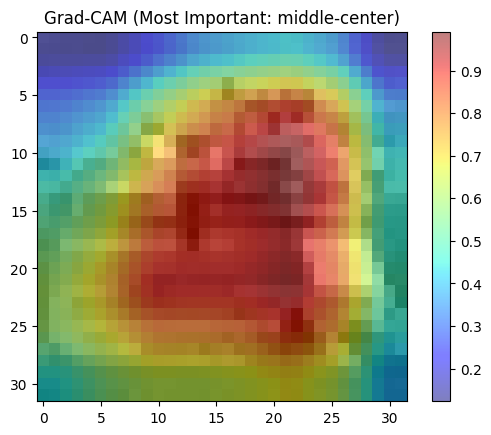

The most important region is: middle-center


In [24]:
ind=0
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Select last convolution layer for Grad-CAM
layer_name = "conv2d_20"
target_layer = model.get_layer(name=layer_name)

# Define a Grad-CAM function
grad_model = tf.keras.models.Model(
    inputs=[model.input],
    outputs=[target_layer.output, model.output]
)

# Compute Grad-CAM
with tf.GradientTape() as tape:
    inputs = np.expand_dims(cnn_input_images_test[ind], axis=0)  # Example image
    inputs_wavelet = np.expand_dims(wavelet_input_features_test[ind], axis=0)
    inputs_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
    tape.watch(inputs_tensor)

    conv_outputs, predictions = grad_model([inputs, inputs_wavelet])
    loss = predictions[0]

grads = tape.gradient(loss, conv_outputs)[0]
weights = tf.reduce_mean(grads, axis=(0, 1))

# Create Grad-CAM heatmap
cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * conv_outputs[..., i]
cam = np.maximum(cam, 0)  # ReLU
cam /= np.max(cam)  # Normalize
cam = np.squeeze(cam)
cam = cv2.resize(cam, (32, 32), interpolation=cv2.INTER_LINEAR)

# Divide the heatmap into a 3x3 grid and calculate the importance of each region
grid_size = 3
region_importance = np.zeros((grid_size, grid_size))

# Calculate the size of each region
region_height = cam.shape[0] // grid_size
region_width = cam.shape[1] // grid_size

for i in range(grid_size):
    for j in range(grid_size):
        region = cam[
            i * region_height: (i + 1) * region_height,
            j * region_width: (j + 1) * region_width
        ]
        region_importance[i, j] = np.sum(region)

# Find the region with the maximum importance
max_region_index = np.unravel_index(np.argmax(region_importance), region_importance.shape)
region_names = [
    ["top-left", "top-center", "top-right"],
    ["middle-left", "middle-center", "middle-right"],
    ["bottom-left", "bottom-center", "bottom-right"],
]
most_important_region = region_names[max_region_index[0]][max_region_index[1]]

# Display Grad-CAM and print the most important region
plt.imshow(cnn_input_images_test[ind].squeeze(), cmap='gray')  # Original image
plt.imshow(cam, cmap='jet', alpha=0.5)  # Grad-CAM overlay
plt.colorbar()
plt.title(f"Grad-CAM (Most Important: {most_important_region})")
plt.show()

print(f"The most important region is: {most_important_region}")
